# LINEAR CLASSIFICATION

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from random import shuffle
from linear_utils import LR

## Getting training data

In [2]:
lr = LR()
# data = pd.read_excel('admision.xlsx')
data = pd.read_csv('diabetes.csv')
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,1,89,66,23,94,28.1,0.167,21,0
1,0,137,40,35,168,43.1,2.288,33,1
2,3,78,50,32,88,31.0,0.248,26,1
3,2,197,70,45,543,30.5,0.158,53,1
4,1,189,60,23,846,30.1,0.398,59,1


## Extracting data

We are going to work with only 2 features: Glucose and Body Mass Index (BMI)

In [56]:
#x1 = np.array([data['Grade1'].values.tolist()]).T
#x2 = np.array([data['Grade2'].values.tolist()]).T
#y = np.array([data['Admitted'].values.tolist()]).T

x1 = np.array([data['Glucose'].values.tolist()]).T
x2 = np.array([data['BMI'].values.tolist()]).T
y = np.array([data['Outcome'].values.tolist()]).T

pos_idx = (y == 1)
neg_idx = (y == 0)

y_pos = np.array([y[pos_idx]]).T
y_neg = np.array([y[neg_idx]]).T

x1_pos = np.array([x1[pos_idx]]).T
x1_neg = np.array([x1[neg_idx]]).T

x2_pos = np.array([x2[pos_idx]]).T
x2_neg = np.array([x2[neg_idx]]).T

print(x1.shape, x2.shape, y.shape)
print(y_pos.shape, y_neg.shape)
print(x1_pos.shape, x1_neg.shape)
print(x2_pos.shape, x2_neg.shape)

(392, 1) (392, 1) (392, 1)
(130, 1) (262, 1)
(130, 1) (262, 1)
(130, 1) (262, 1)


## Data randomization, split and normalization

In [57]:
# Create matrix
x = np.concatenate([x1, x2], axis=1)

# Randomize
idx = [i for i in range(len(x))]
shuffle(idx)
x = x[idx] 
y = y[idx]

# Normalize
x_norm = (x - x.min(0)) / x.ptp(0)
y_norm = (y - y.min(0)) / y.ptp(0)
x_b = np.insert(x_norm, 0, 1, axis=1)

# Split 70% / 30%
x_train = x_b[0:round(0.7*x_b.shape[0])]
x_test = x_b[round(0.7*x_b.shape[0]):]
y_train = y_norm[0:round(0.7*y.shape[0])]
y_test = y_norm[round(0.7*y.shape[0]):]

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(274, 3) (118, 3) (274, 1) (118, 1)


## Graphing data

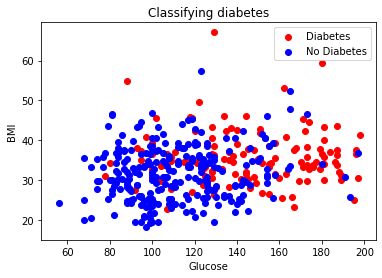

In [58]:
plt.figure()
plt.title('Classifying diabetes')
plt.xlabel('Glucose')
plt.ylabel('BMI')
plt.scatter(x1_pos[:,0], x2_pos[:,0], color='r', label='Diabetes')
plt.scatter(x1_neg[:,0], x2_neg[:,0], color='b', label='No Diabetes')
plt.legend()

## Hypothesis

In [59]:
def h(x, w):
    """
        params:
            w: [np_array] a vector of weights with dimensions (nx1), where n represents the number of weights.
            x: [np_array] a vector of feature variables with dimensions (m x n)
        return
            h: [mp_array] a vector of dimensons (m x 1) representing all predictions
    """
    return 1 / (1 + np.exp(-x.dot(w)))

w_i = np.zeros([3, 1])
print(h(x_b, w_i).shape)

(392, 1)


## Cost function

$$ J(w) = -\sum_{i=1}^{m} y^{(i)} log(h(x^{(i)})) + (1 - y^{(i)}) log(1-y^{(i)}) + \lambda w^{T}w$$

In [60]:
def cost(w, x, y, l2=0):
    """
        params:
            w: [np_array] a vector of weights with dimensions (nx1), where n represents the number of weights.
            x: [np_array] a vector of feature variables with dimensions (m x n),
                where n represents the number of feature variables and m the number of training examples
            y: [np_array] a vector of feature variables with dimensions (m x 1),
                where m represents the number of target variables
            l2: [double] regularization constant for Ridge Regression

        returns:
            cost: [double] the mean squared error
    """
    return -( y.T.dot(np.log(h(x, w))) + (1 - y).T.dot(np.log(1 - h(x, w))) )[0][0] + l2*w.T.dot(w)[0][0]

print(cost(w_i, x_b, y_norm))

271.71369477949855


## Gradient

$$ \nabla_{w} J(w) = [y - h(x)]x$$

In [61]:
def grad(w, x, y, l2=0):
    """
        params:
            w: [np_array] a vector of weights with dimensions (nx1), where n represents the number of weights.
            x: [np_array] a vector of feature variables with dimensions (m x n),
                where n represents the number of feature variables and m the number of training examples
            y: [np_array] a vector of feature variables with dimensions (mx1),
                where m represents the number of target variables
            l2: [double] regularization constant for Ridge Regression

        returns:
            grad: [double] the derivative of the mean squared error
    """
    e = h(x, w) - y
    return (1 / (x.shape[0])) * x.T.dot(e) + l2*w

print(grad(w_i, x_b, y))
print(grad(w_i, x_b, y).shape)

[[0.16836735]
 [0.02630066]
 [0.03300154]]
(3, 1)


## Gradient Descent

$$ w := w - \alpha \nabla_{w} J(w)$$

In [62]:
def fit_gd(x_train, y_train, x_test, y_test, num_iter, alpha, w=None, l2=0, show_progress=True):
    """
        We calculate gradient descent for minimizing the MSE to obtain the best linear hypothesis.

        params:
            x_train: [np_array] a vector of feature variables with dimensions (mxn),
                      where n represents the number of feature variables and m the number of training examples
            x_test: [np_array] a vector of feature variables with dimensions (mxn),
                      where n represents the number of feature variables and m the number of validation examples
            y_train: [np_array] a vector of feature variables with dimensions (mx1),
                where m represents the number of target training variables
            y_test: [np_array] a vector of feature variables with dimensions (mx1),
                where m represents the number of target validation variables
            num_iter: [int] an integer indicating the number of iterations of the Gradient Descent algorithm
            alpha: [double] learning rate constant specifying the magnitude update step
            w: [np_array] vector that contains the initial weights to optimize the model with dimensions (n x 1)
            l2: [double] regularization constant for Ridge Regression

        return:
            j_train: [np_array] a vector (num_iter x 1) containing all cost function evaluations during training
            j_test: [np_array] a vector (num_iter x 1) containing all cost function evaluations during evaluation
            w: [np_array] a vector of the final optimized weights with dimensions (nx1)
    """

    if w is None:
        # Random weight initialization
        w = np.random.randn(x_train.shape[1], 1)

    # Vectors to save all costs at each iteration
    j_train = np.zeros(num_iter)
    j_test = np.zeros(num_iter)

    # Iterate over the specified range
    for i in range(num_iter):

        # Update weights using Gradient Descent
        w = w - alpha * grad(w, x_train, y_train, l2=l2)

        # Save training cost
        j_train[i] = cost(w, x_train, y_train, l2=l2)

        # Save validation cost
        j_test[i] = cost(w, x_test, y_test, l2=l2)
        
        # Show cost
        if show_progress:
            print('Validation cost {0}'.format(j_test[i]))

    return w, j_train, j_test


num_iter = 7000
alpha = 0.1
it = np.linspace(0 ,num_iter, num_iter)
w_best, j_train, j_test = fit_gd(x_train, y_train, x_test, y_test, num_iter, alpha, show_progress=False)

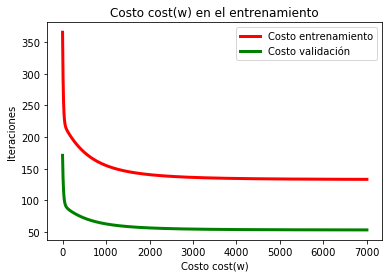

In [63]:
# Graficamos el costo
plt.figure()
plt.plot(it, j_train, 'r', linewidth=3, label='Costo entrenamiento')
plt.plot(it, j_test, 'g', linewidth=3, label='Costo validación')
plt.title('Costo cost(w) en el entrenamiento')
plt.xlabel('Costo cost(w)')
plt.ylabel('Iteraciones')
plt.legend()

In [64]:
# Denormalizamos predicciones
preds = h(x_test, w_best)
preds = preds * y.ptp(0) + y.min(0)

# Binarize predictions
preds = np.where(preds>0.5, 1, 0)

# Get accuracy, sensitivity, specificty
tp = np.sum(np.logical_and(preds == 1, y_test == 1))
tn = np.sum(np.logical_and(preds == 0, y_test == 0))
fp = np.sum(np.logical_and(preds == 1, y_test == 0))
fn = np.sum(np.logical_and(preds == 0, y_test == 1))

sens = tp / (tp + fn)
spec = tn / (tn + fp)
acc = (tp + tn) / (tp + tn + fp+ fn)
prec  = tp / (tp + fp)
f1 = 2*prec*sens / (prec + sens)

print('Sensitivity: ', sens*100)
print('Specificity: ', spec*100)
print('Accuracy: ', acc*100)
print('Precision: ', prec*100)
print('F1 Score: ', f1*100)

Sensitivity:  55.88235294117647
Specificity:  89.28571428571429
Accuracy:  79.66101694915254
Precision:  67.85714285714286
F1 Score:  61.29032258064516


## Decision Boundary

$$ x_{2} = - \frac {w_{0} + w_{1}x_{1}} {w_{2}} $$

(130,)


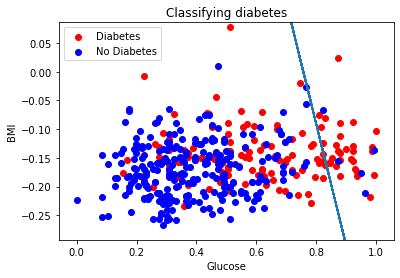

In [65]:
# Normalize pos and neg data
x1_norm = (x1 - x1.min(0)) / x1.ptp(0)
x2_norm = (x2 - x2.min(0)) / x2.ptp(0)

x1_pos_norm = (x1_pos - x.min(0)) / x.ptp(0)
x1_neg_norm = (x1_neg - x.min(0)) / x.ptp(0)

x2_pos_norm = (x2_pos - x.min(0)) / x.ptp(0)
x2_neg_norm = (x2_neg - x.min(0)) / x.ptp(0)

x2_lin = -(w_best[0][0] + w_best[1][0]*x1_norm) / w_best[2][0]

print(x2_pos_norm[:,0].shape)
# Plot decision boundary
plt.figure()
plt.title('Classifying diabetes')
plt.xlabel('Glucose')
plt.ylabel('BMI')
plt.ylim(1.1*min(x2_neg_norm[:,0]), 1.1*max(x2_pos_norm[:,0]))
plt.scatter(x1_pos_norm[:,0], x2_pos_norm[:,0], color='r', label='Diabetes')
plt.scatter(x1_neg_norm[:,0], x2_neg_norm[:,0], color='b', label='No Diabetes')
plt.plot(x1_norm, x2_lin)
plt.legend()

# Logistic regression for "n" features

We are going to analyze logistic regression with "n" features:

In [74]:
x_data = data.loc[:, data.columns != 'Outcome'].values
y_data = np.array([data['Outcome'].values]).T
print(x_data.shape, y_data.shape)

(392, 8) (392, 1)


We pre-process all data: normalization, splitting and randomization

In [75]:
# Normalize features (each column)
x_data_norm = (x_data - x_data.min(0)) / x_data.ptp(0)

# Randomize
idx = [i for i in range(len(y_data))]
shuffle(idx)
x = x[idx] 
y = y[idx]

# We split training data and add bias
x_b = np.insert(x_data_norm, 0, 1, axis=1)

# Split 70% / 30%
x_train = x_b[0:round(0.7*x_b.shape[0])]
x_test = x_b[round(0.7*x_b.shape[0]):]
y_train = y_norm[0:round(0.7*y.shape[0])]
y_test = y_norm[round(0.7*y.shape[0]):]

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(274, 9) (118, 9) (274, 1) (118, 1)


Run gradient descent:

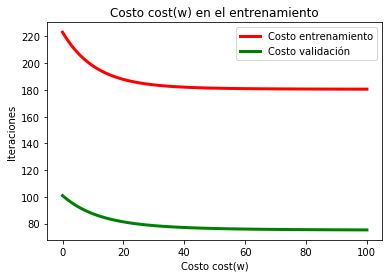

In [76]:
num_iter = 100
alpha = 0.1
it = np.linspace(0 ,num_iter, num_iter)
w_best, j_train, j_test = fit_gd(x_train, y_train, x_test, y_test, num_iter, alpha, show_progress=False)

# Graficamos el costo
plt.figure()
plt.plot(it, j_train, 'r', linewidth=3, label='Costo entrenamiento')
plt.plot(it, j_test, 'g', linewidth=3, label='Costo validación')
plt.title('Costo cost(w) en el entrenamiento')
plt.xlabel('Costo cost(w)')
plt.ylabel('Iteraciones')
plt.legend()

We get final metrics of classification

In [77]:
# Denormalizamos predicciones
preds = h(x_test, w_best)

# Binarize predictions
preds = np.where(preds>0.5, 1, 0)

# Get accuracy, sensitivity, specificty
tp = np.sum(np.logical_and(preds == 1, y_test == 1))
tn = np.sum(np.logical_and(preds == 0, y_test == 0))
fp = np.sum(np.logical_and(preds == 1, y_test == 0))
fn = np.sum(np.logical_and(preds == 0, y_test == 1))

sens = tp / (tp + fn)
spec = tn / (tn + fp)
acc = (tp + tn) / (tp + tn + fp+ fn)
prec  = tp / (tp + fp)
f1 = 2*prec*sens / (prec + sens)

print('Sensitivity: ', sens*100)
print('Specificity: ', spec*100)
print('Accuracy: ', acc*100)
print('Precision: ', prec*100)
print('F1 Score: ', f1*100)

Sensitivity:  5.88235294117647
Specificity:  92.85714285714286
Accuracy:  67.79661016949152
Precision:  25.0
F1 Score:  9.523809523809524
